# PGD 적대적 학습과 일반 학습 성능 비교해보기

## 1. 필요한 라이브러리 import

### 1-1. Tensorflow 및 numpy 설치

In [20]:
! pip install tensorflow
! pip install numpy


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1-2. 필요한 라이브러리 Import 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 2. 함수 정의

### 2-1. 이미지 전처리 - 이전 예제와 동일

In [2]:
def load_preprocess_fashion_mnist():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    train_images = np.expand_dims(train_images, -1)
    test_images = np.expand_dims(test_images, -1)
    return train_images, train_labels, test_images, test_labels

### 2-2. 적대적 샘플 생성 함수 - 이전 예제와 동일

In [3]:
def create_adversarial_pattern(input_image, input_label, model, epsilon=0.01, num_steps=10, step_size=0.01):
    adv_image = tf.identity(input_image)
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)
        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, adv_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        adv_image = adv_image + step_size * signed_grad
        adv_image = tf.clip_by_value(adv_image, input_image - epsilon, input_image + epsilon)
    return adv_image

## 3. 모델 로드
이전 예제에서 학습해둔 가중치 모델 파일을 로드합니다.

In [4]:
# 모델 로드 함수
def load_model(path):
    return tf.keras.models.load_model(path)

# 모델 로드
model_natural_loaded = load_model('model_natural.h5')
model_adversarial_loaded = load_model('model_adversarial_iter10.h5')

## 4. 모델 비교
동일한 테스트 이미지를 선택하여 두 모델에 각각 입력하여 추론해봅시다.

### 4-1. 추론 결과 시각화 함수 정의

In [5]:
def display_adversarial_examples(model_natural, model_adversarial, image, label, epsilon = 0.1, num_steps=10, step_size=0.01):
    
    label_names = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }
    # 실제 레이블의 이름과 신뢰도 가져오기
    actual_label_name = label_names[label.numpy()[0]]  # label은 텐서이므로 numpy로 변환 후 인덱싱

    # PGD로 적대적 예제 생성
    perturbations = create_adversarial_pattern(image, label, model_natural, epsilon=epsilon, num_steps=num_steps, step_size=step_size)
    adv_image = image + perturbations
    adv_image = tf.clip_by_value(adv_image, 0, 1)

    # 원본 이미지에 대한 예측 및 신뢰도 계산
    preds_original_natural = model_natural.predict(image)
    preds_original_adversarial = model_adversarial.predict(image)
    confidence_original_natural = np.max(tf.nn.softmax(preds_original_natural, axis=1).numpy()) * 100
    confidence_original_adversarial = np.max(tf.nn.softmax(preds_original_adversarial, axis=1).numpy()) * 100

    # 적대적 예제에 대한 예측 및 신뢰도 계산
    preds_adv_natural = model_natural.predict(adv_image)
    preds_adv_adversarial = model_adversarial.predict(adv_image)
    confidence_adv_natural = np.max(tf.nn.softmax(preds_adv_natural, axis=1).numpy()) * 100
    confidence_adv_adversarial = np.max(tf.nn.softmax(preds_adv_adversarial, axis=1).numpy()) * 100

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(image[0, :, :, 0], cmap='gray')
    axes[0].set_title(f'Original Image\nActual: {actual_label_name}\nNatural: {label_names[np.argmax(preds_original_natural)]} ({confidence_original_natural:.2f}%)\nAdversarial: {label_names[np.argmax(preds_original_adversarial)]} ({confidence_original_adversarial:.2f}%)')
    axes[1].imshow(adv_image[0, :, :, 0], cmap='gray')
    axes[1].set_title(f'Adversarial Image\nActual: {actual_label_name}\nNatural: {label_names[np.argmax(preds_adv_natural)]} ({confidence_adv_natural:.2f}%)\nAdversarial: {label_names[np.argmax(preds_adv_adversarial)]} ({confidence_adv_adversarial:.2f}%)')
    for ax in axes:
        ax.axis('off')
    plt.show()

### 4-2. 추론 및 결과 시각화

1/1 [==============================] - 0s 11ms/step


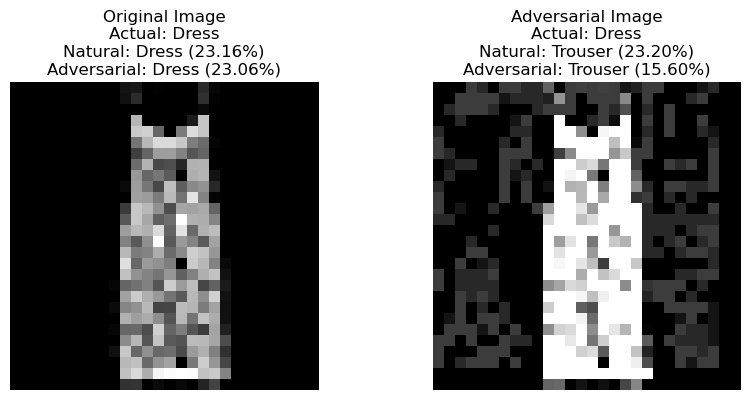

1/1 [==============================] - 0s 11ms/step


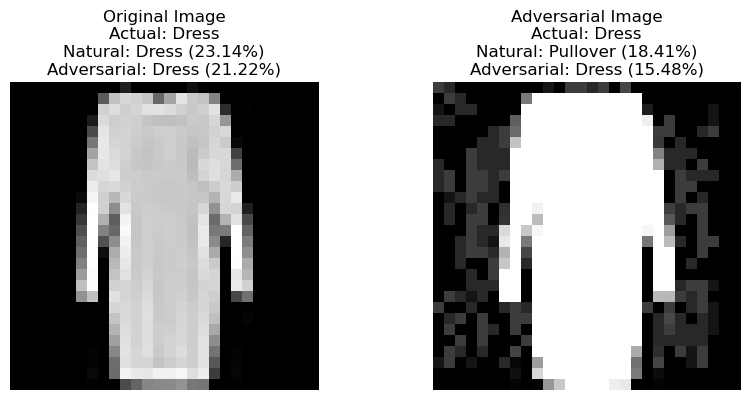

1/1 [==============================] - 0s 11ms/step


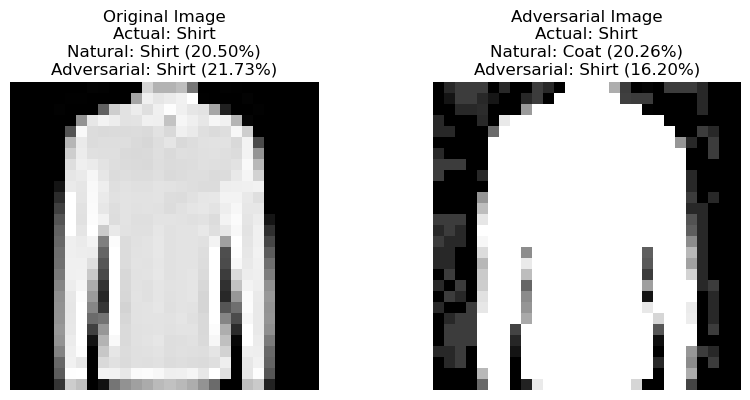

1/1 [==============================] - 0s 11ms/step


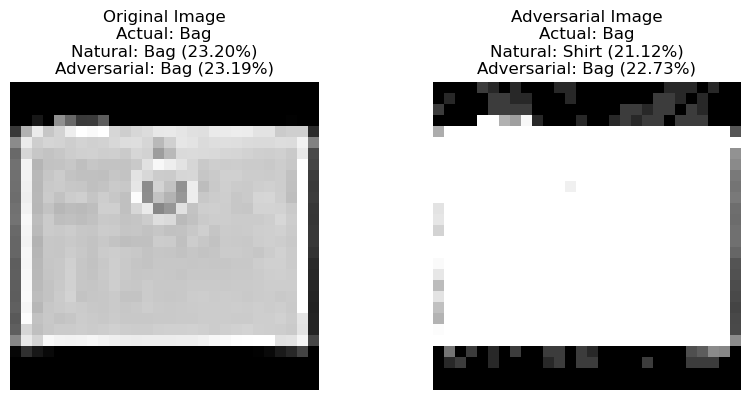

1/1 [==============================] - 0s 10ms/step


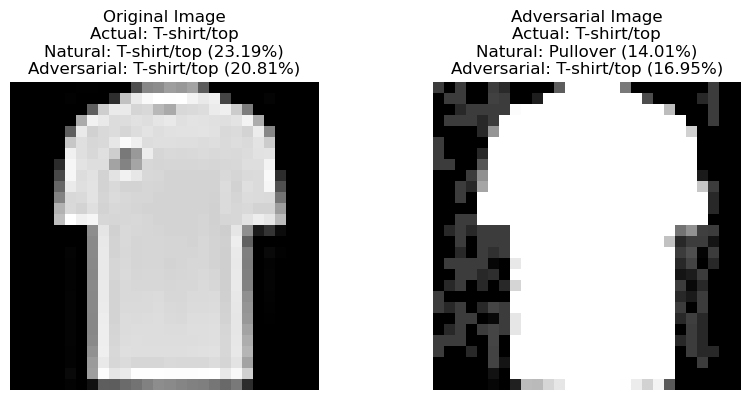

1/1 [==============================] - 0s 10ms/step


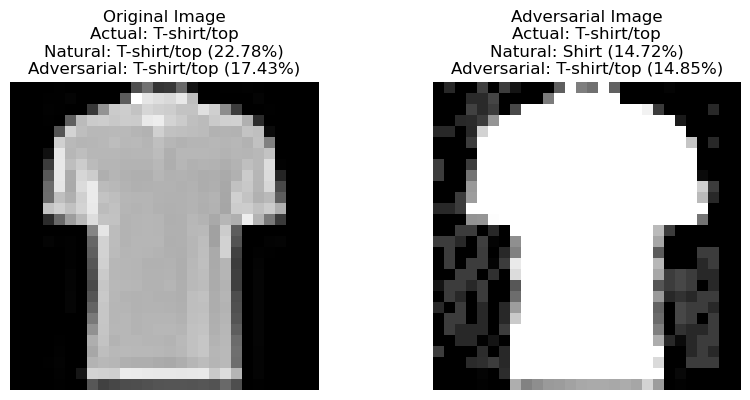

1/1 [==============================] - 0s 11ms/step


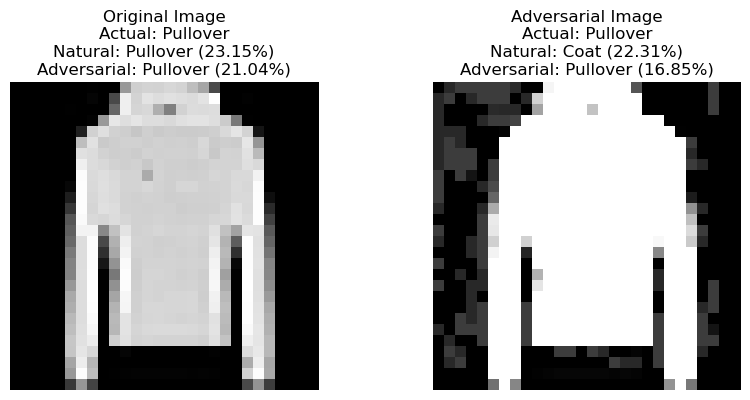

1/1 [==============================] - 0s 17ms/step


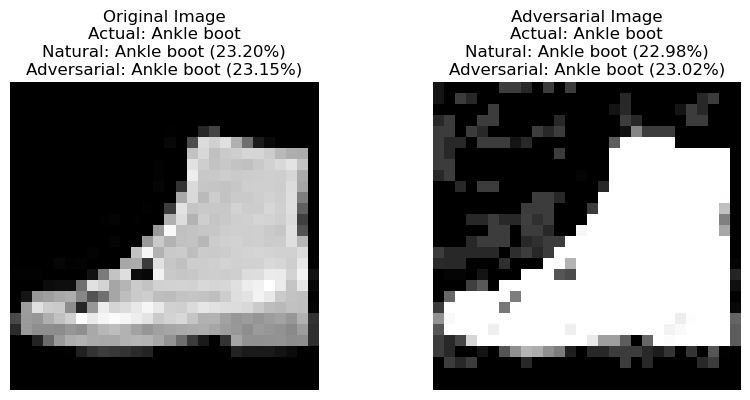

1/1 [==============================] - 0s 11ms/step


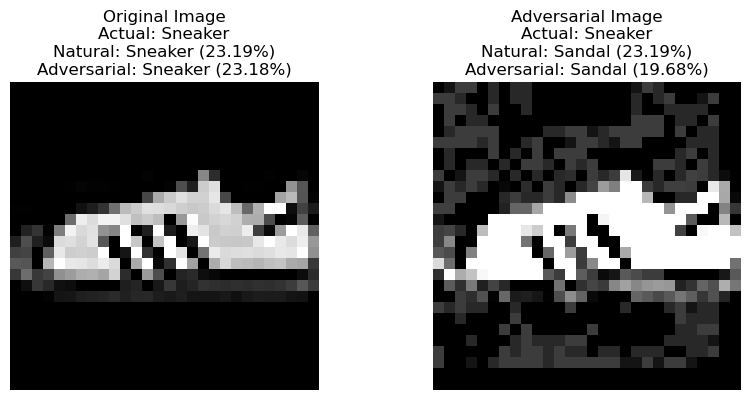

1/1 [==============================] - 0s 11ms/step


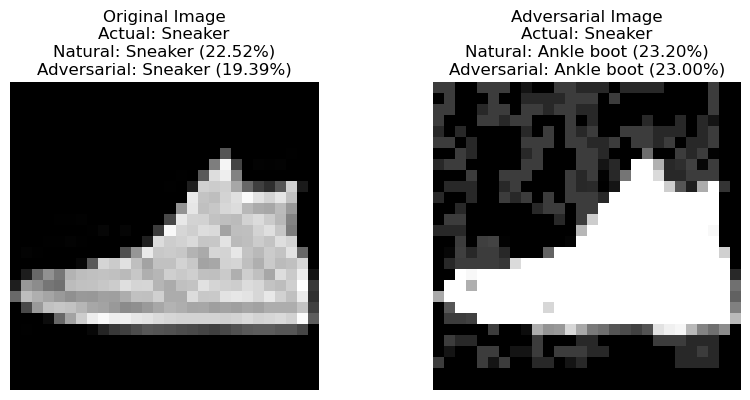

In [134]:
train_images, train_labels, test_images, test_labels = load_preprocess_fashion_mnist()

for i in range(10):
    test_idx = 300 + i # Fashion-MNIST의 test set에서 test_idx번 째 이미지를 선택
    image = tf.expand_dims(test_images[test_idx], 0)
    label = tf.expand_dims(test_labels[test_idx], 0)
    # display_adversarial_examples 함수 실행
    # Natural 23.05
    # Adver 23.04
    epsilon = 0.2399 # 0.28
    num_steps = 10 # 10
    step_size = 0.08 # 0.1
    display_adversarial_examples(model_natural_loaded, model_adversarial_loaded, image, label, epsilon = epsilon, num_steps=num_steps, step_size=step_size)